In [1]:
import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from os import path


filename=[]
target_corners='output_images/corners/corners_' 
target_undist='output_images/undistorted/undist_' 
target_pipeline_comb='output_images/pipeline/comb_' 
target_warped='output_images/warped/warped_'
target_perspective='output_images/warped/perspective_'

In [3]:
def cam_cali(objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


def cal_undistort(img, objpoints, imgpoints, mtx, dist):
    ''' Function that takes an image, object points, and image points 
    performs the camera calibration, image distortion correction 
    and returns the undistorted image '''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 

def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    grad_binary.astype(int)
    # Return the result
    return grad_binary


def mag_thresh(img, sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= thresh[0]) & (gradmag <= thresh[1])] = 1
    mag_binary.astype(int)
    # Return the binary image
    return mag_binary


def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction,
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    dir_binary.astype(int)
    # Return the binary image
    return dir_binary


def color_threshold(img, s_thresh=(0,255), v_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])  ] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])  ] = 1

    color_binary = np.zeros_like(s_channel)
    color_binary[(s_binary == 1) & (v_binary == 1)] = 1
    return color_binary


def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped



In [4]:
'''---Camera Calibration---------------------------------------------------------------------------------------------------'''

# Read in a image, find the CheesboardCorners and save the image with the corners 
objpoints=[]
imgpoints=[]

objp = np.zeros((9*6,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1, 2)

for filepath in glob.glob('camera_cal/*.jpg'): 
    img = mpimg.imread(filepath)
    file=filepath.split('\\')
    filename=file[1]
    #cv2.imshow('img_orig',img)
    #cv2.waitKey(500)
    
    # Convert to grayscale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    #cv2.imshow('img_gray',gray)
    #cv2.waitKey(500)
    
    # Find the CheesboardCorners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    print(ret)
    
    # CheesboardCorners found, add object points and image points, save the image with the corners
    # run the image distortion correction and save the undistorted images
    if ret == True:
        
        imgpoints.append(corners)
        objpoints.append(objp)
        
        mtx = cam_cali(objpoints, imgpoints)[1]      
        dist = cam_cali(objpoints, imgpoints)[2]
                     
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #cv2.imshow('img_corners',img)
        #cv2.waitKey(500)
        #print (target+filename)
        mpimg.imsave(target_corners+filename,img)
        undistorted = cal_undistort(img, objpoints, imgpoints, mtx, dist)
        #cv2.imshow('img_undist',undistorted)
        #cv2.waitKey(500)
        mpimg.imsave(target_undist+filename,undistorted)        

       
cv2.destroyAllWindows()



False
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
True
True
True
True


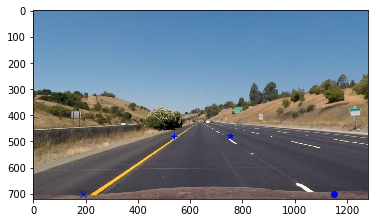

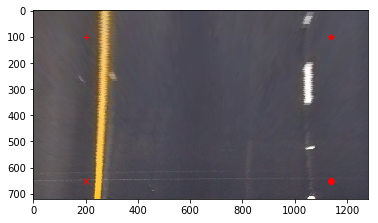

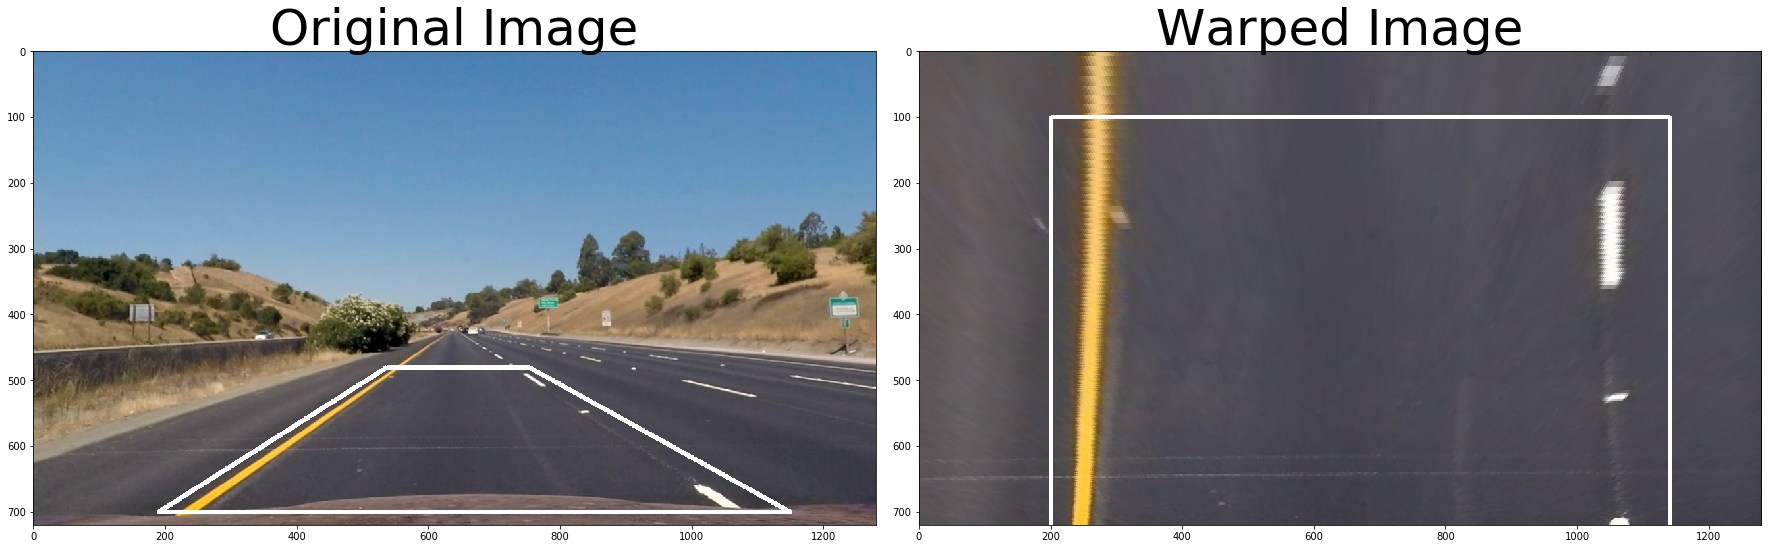

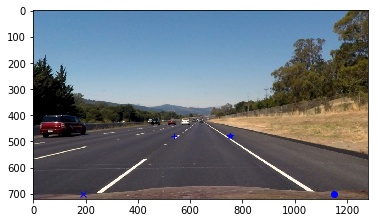

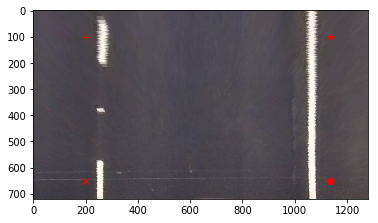

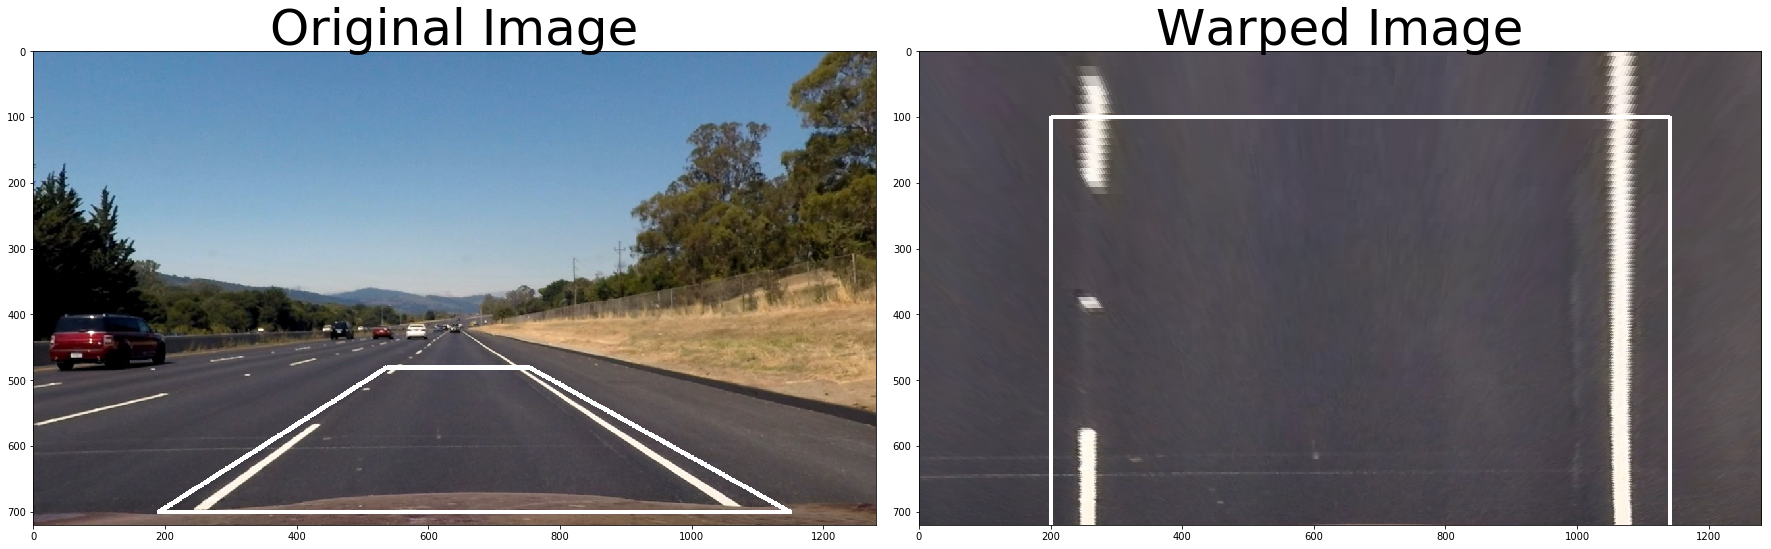

In [5]:
'''Perspective Transform of the Straight Line Test Data for Output Images'''

for filepath in glob.glob('output_images/undistorted/*straight_lines*.jpg'):
    img = mpimg.imread(filepath)
    file=filepath.split('\\')
    filename=file[1]
    
    src=np.float32([[753,480],
                    [537,480],
                    [190,700],
                    [1150,700]])

    
    dst=np.float32([[1140,100],
                    [200,100],
                    [200,740],
                    [1140,740]])
    
    binary_warped=warper(img, src, dst) 
    
    #Plot the src points on the original image
    plt.figure()   
    plt.imshow(img)
    plt.plot(537,480,'+',color='b')#top left
    plt.plot(753,480,'*',color='b')#top right
    plt.plot(190,700,'x',color='b') #bottom left
    plt.plot(1150,700,'o',color='b')#bottom right
    
    #Plot the dst points on the warped image
    plt.figure()
    plt.imshow(binary_warped)
    plt.plot(200,100,'+',color='r')#top left
    plt.plot(1140,100,'*',color='r')#top right
    plt.plot(200,650,'x',color='r') #bottom left
    plt.plot(1140,650,'o',color='r')#bottom right
    
    #Plot the distorted rectangle on the original image
    pts = np.array(src, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(img,[pts],True,1000,5)
    
    #Plot the undistorted rectangle on the warped image
    pts = np.array(dst, np.int32)
    pts = pts.reshape((-1,1,2))
    cv2.polylines(binary_warped,[pts],True,(255,0,255),5)
    
    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f1.tight_layout()

    ax1.imshow(img)
    ax1.set_title('Original Image', fontsize=50)
    ax2.imshow(binary_warped)
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
    'Save image for the output folder'
    f1.savefig(target_perspective+filename)


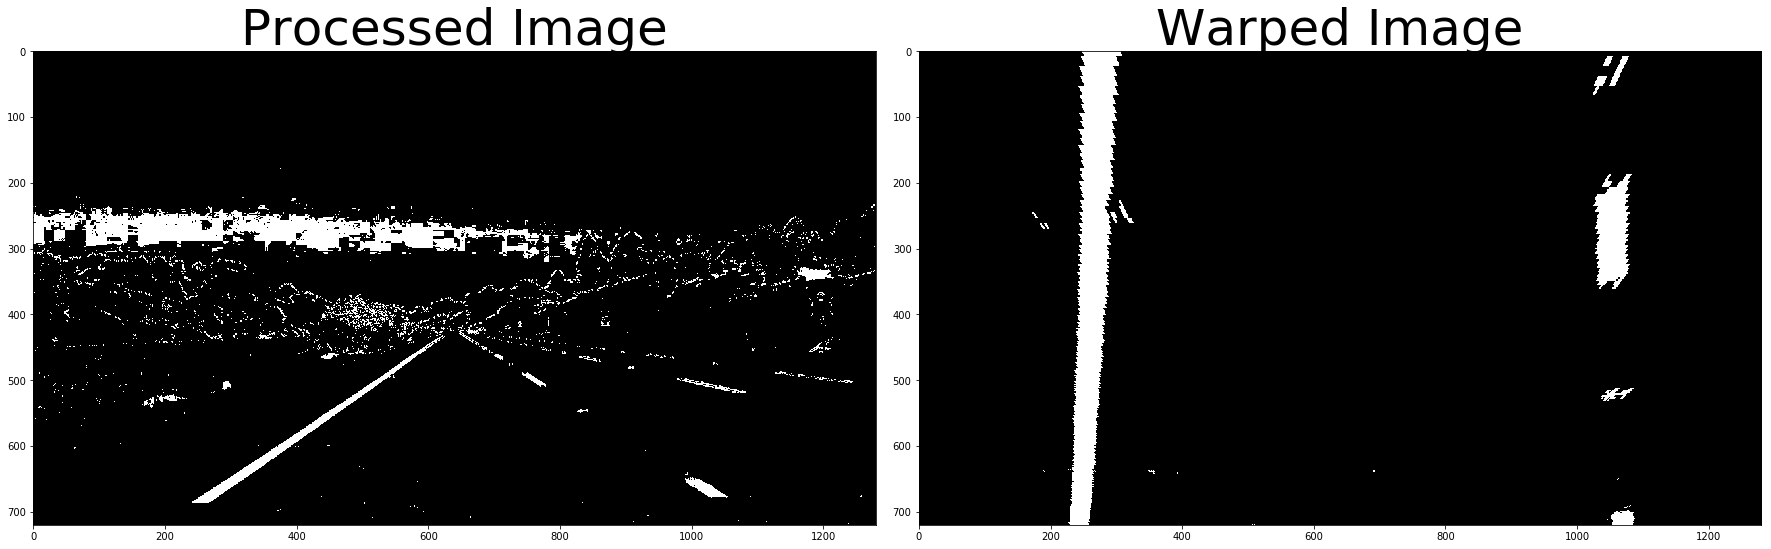

Left Curvature 4280.08 m
Right Curvature 2921.39 m
Vehicle Offset from the Middle -0.08 m
Average Curvature 3600.74 m


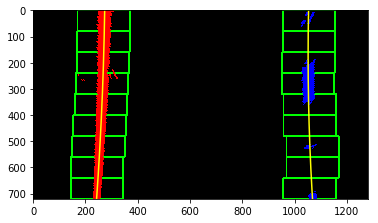

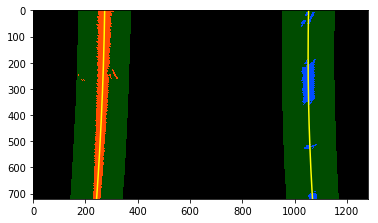

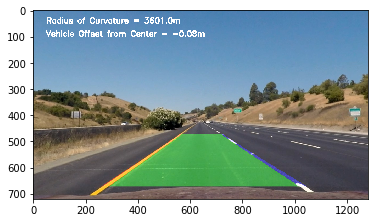

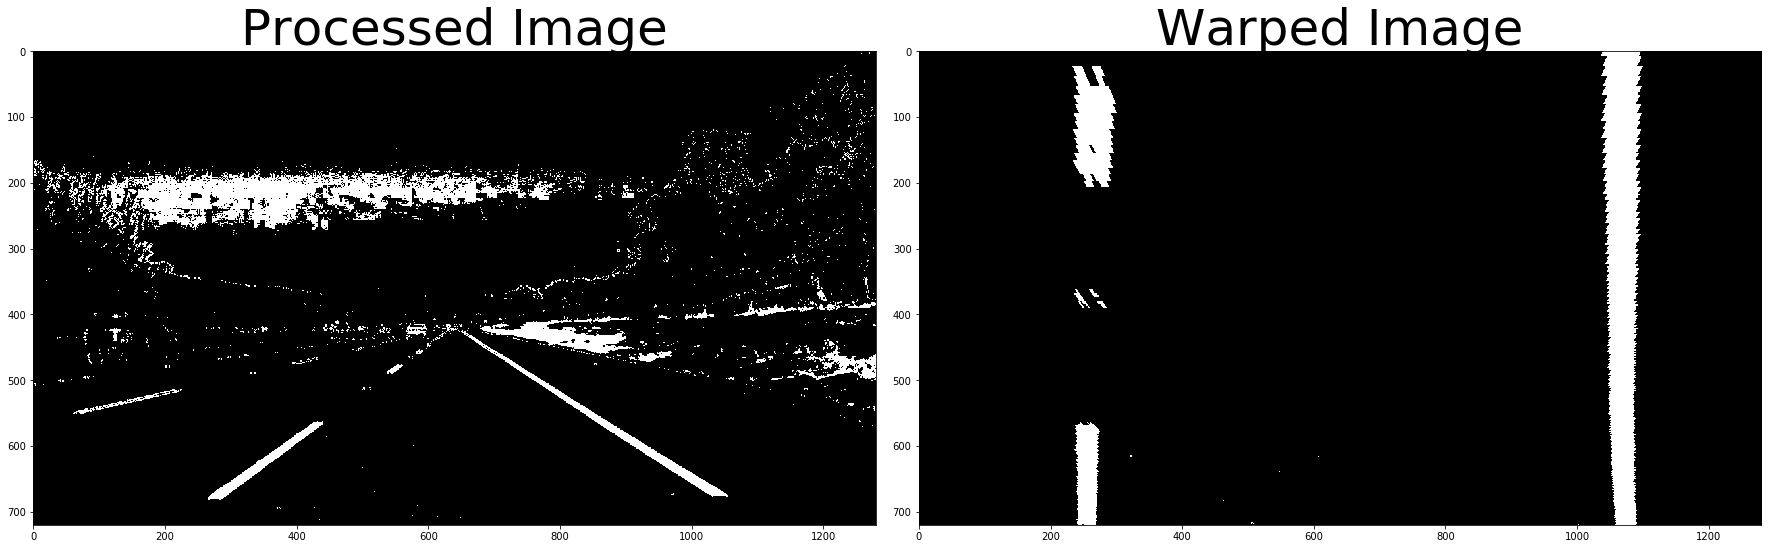

Left Curvature 4491.84 m
Right Curvature 10480.76 m
Vehicle Offset from the Middle -0.11 m
Average Curvature 7486.30 m


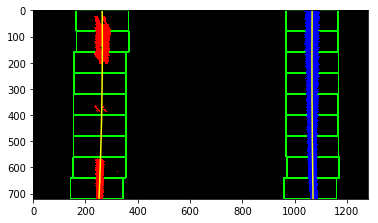

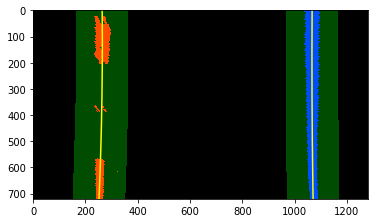

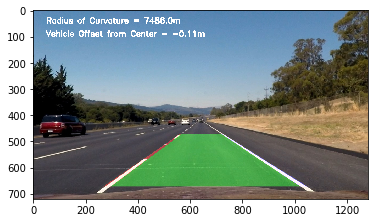

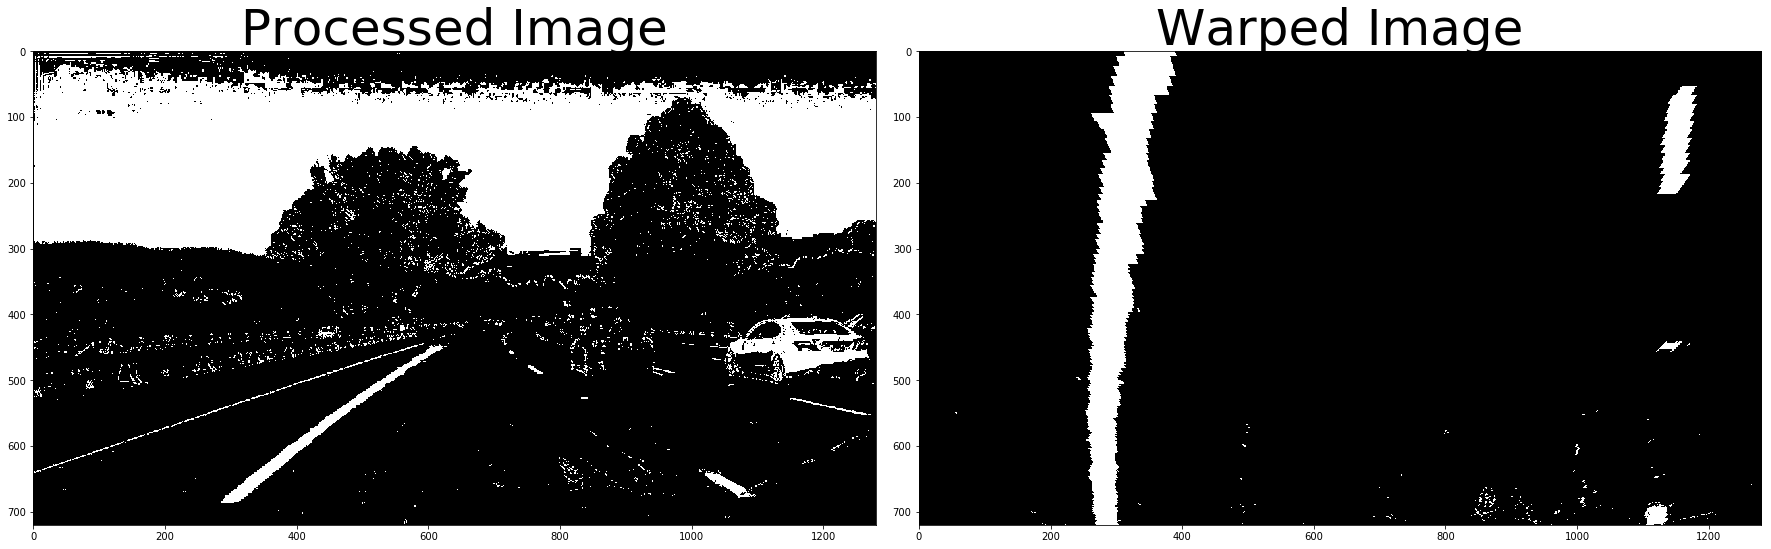

Left Curvature 1171.41 m
Right Curvature 2029.02 m
Vehicle Offset from the Middle -0.32 m
Average Curvature 1600.22 m


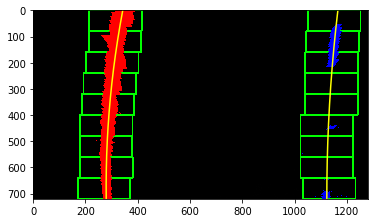

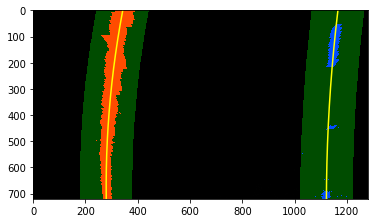

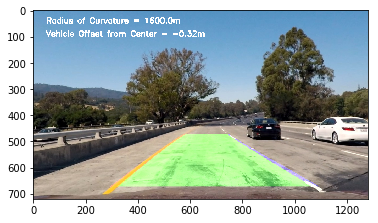

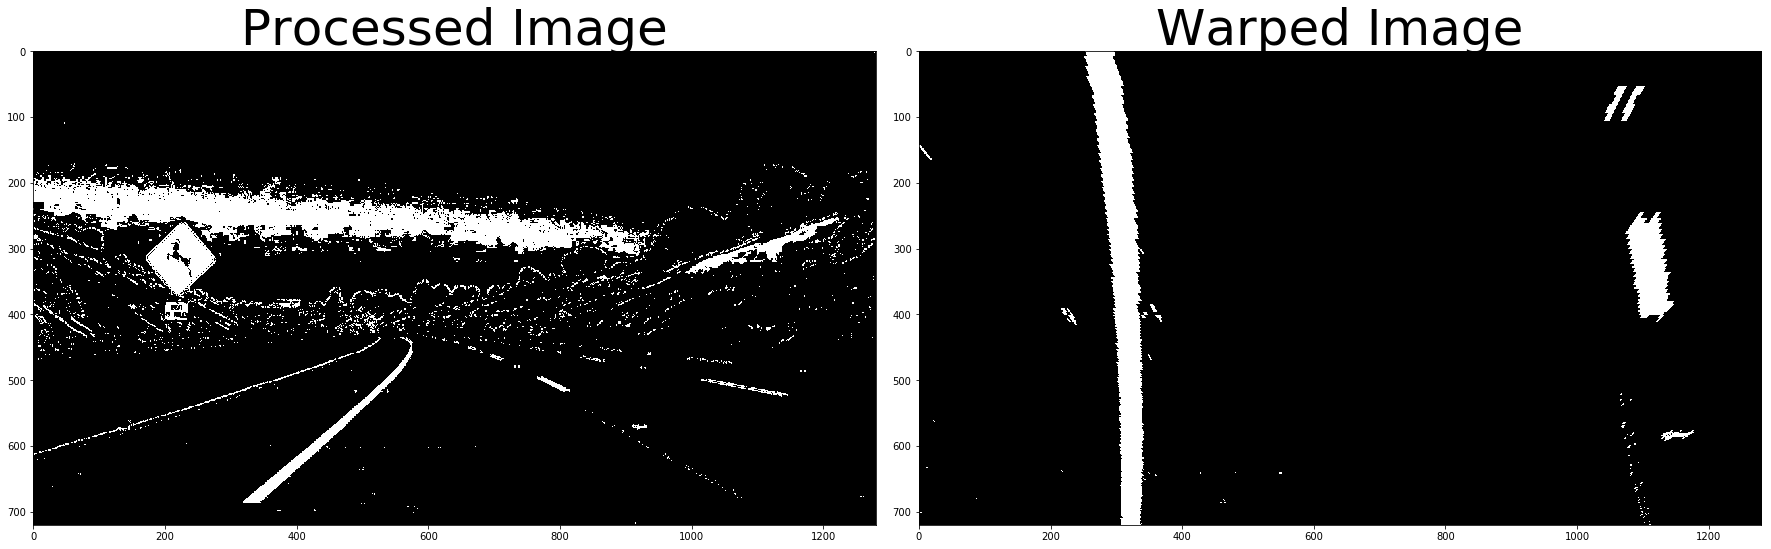

Left Curvature 1384.39 m
Right Curvature 797.97 m
Vehicle Offset from the Middle -0.42 m
Average Curvature 1091.18 m


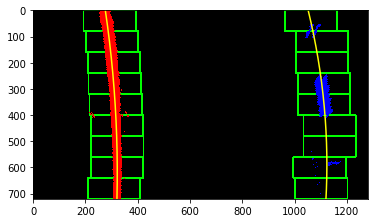

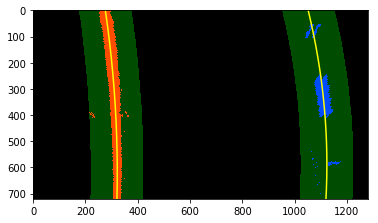

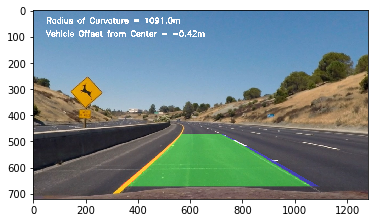

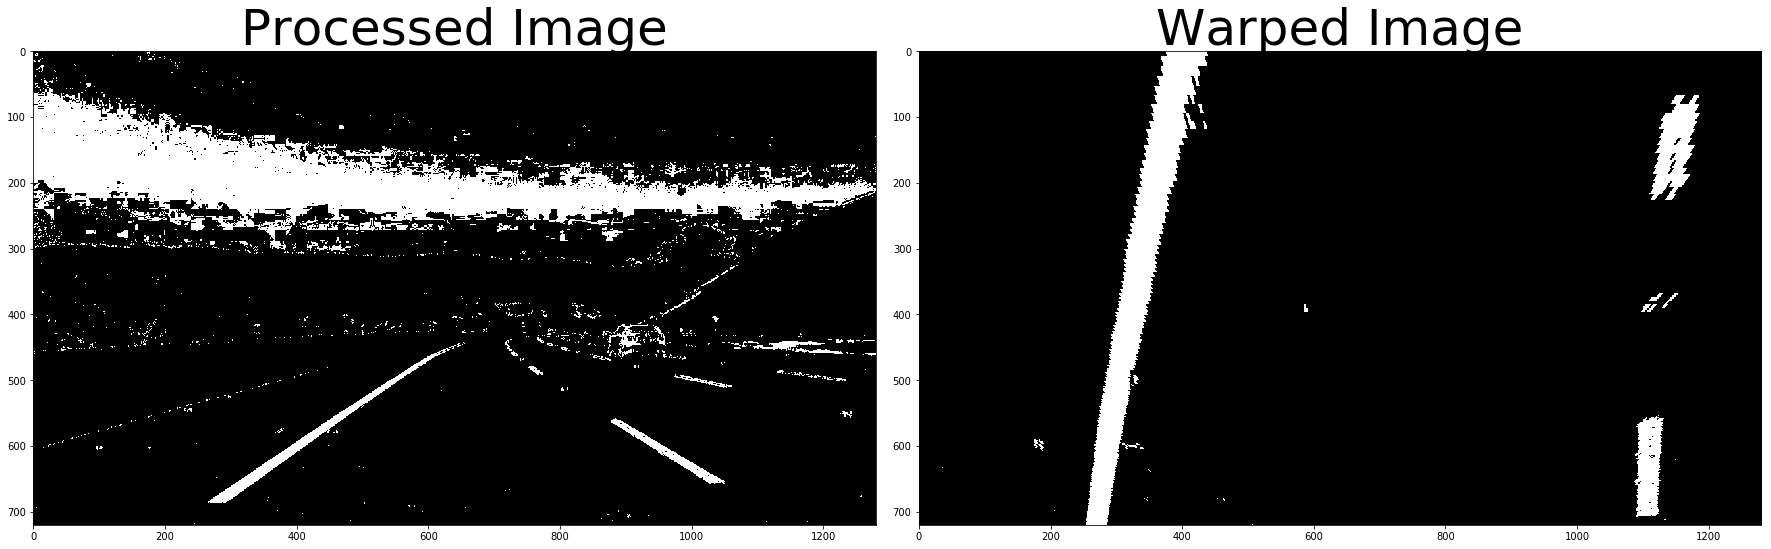

Left Curvature 2772.43 m
Right Curvature 1009.20 m
Vehicle Offset from the Middle -0.25 m
Average Curvature 1890.81 m


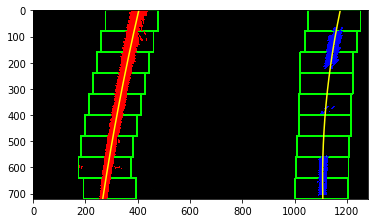

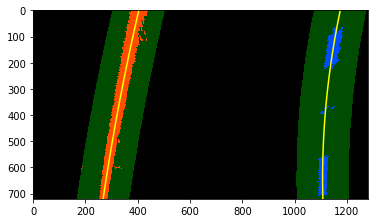

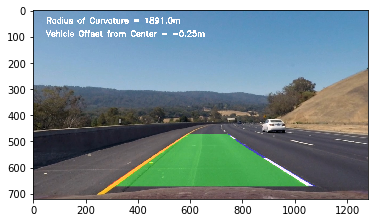

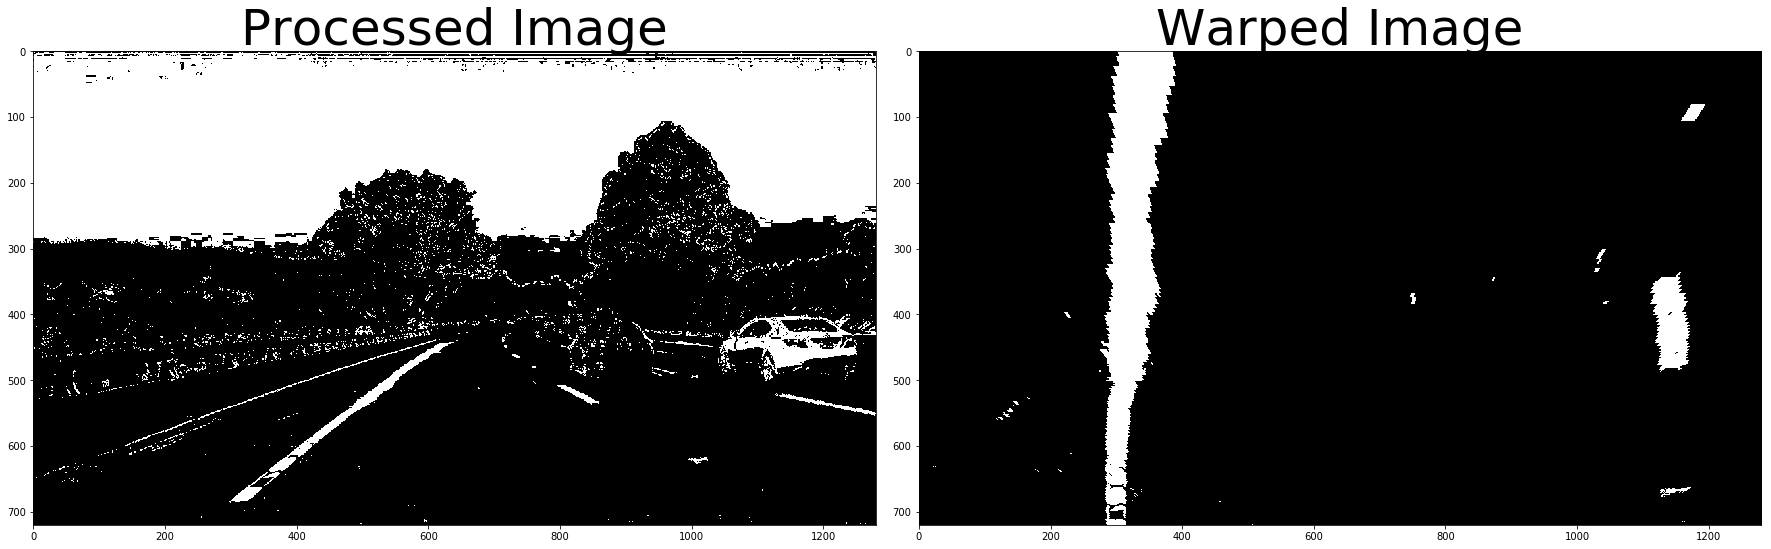

Left Curvature 106352.23 m
Right Curvature 636.03 m
Vehicle Offset from the Middle -0.46 m
Average Curvature 53494.13 m


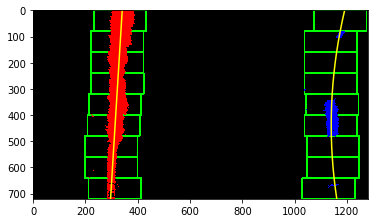

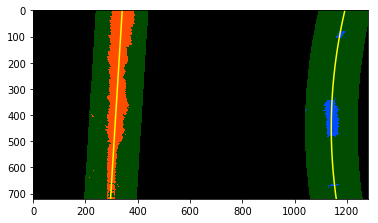

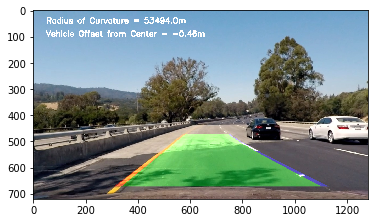

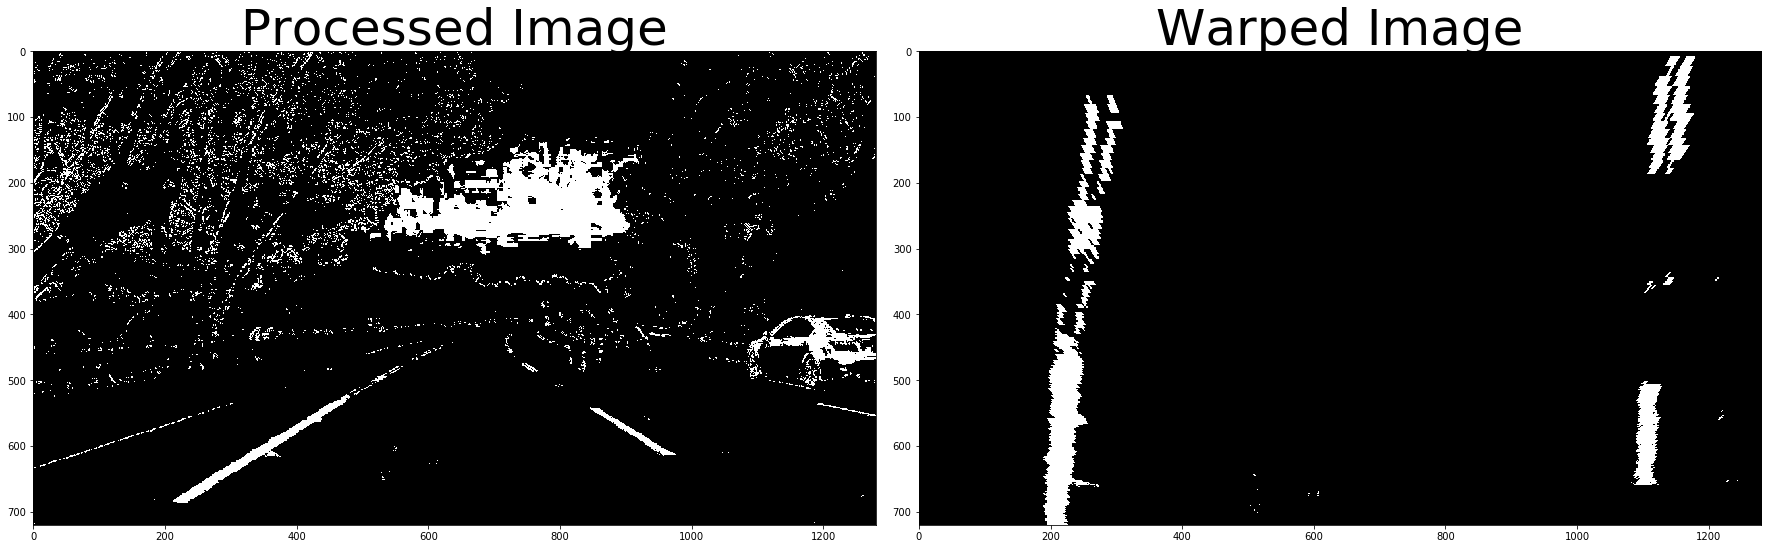

Left Curvature 1585.91 m
Right Curvature 2495.19 m
Vehicle Offset from the Middle -0.08 m
Average Curvature 2040.55 m


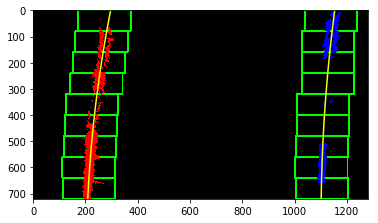

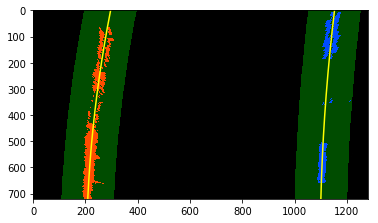

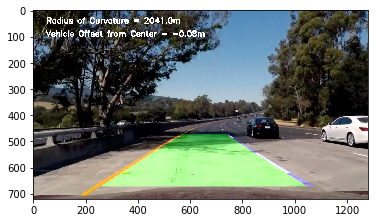

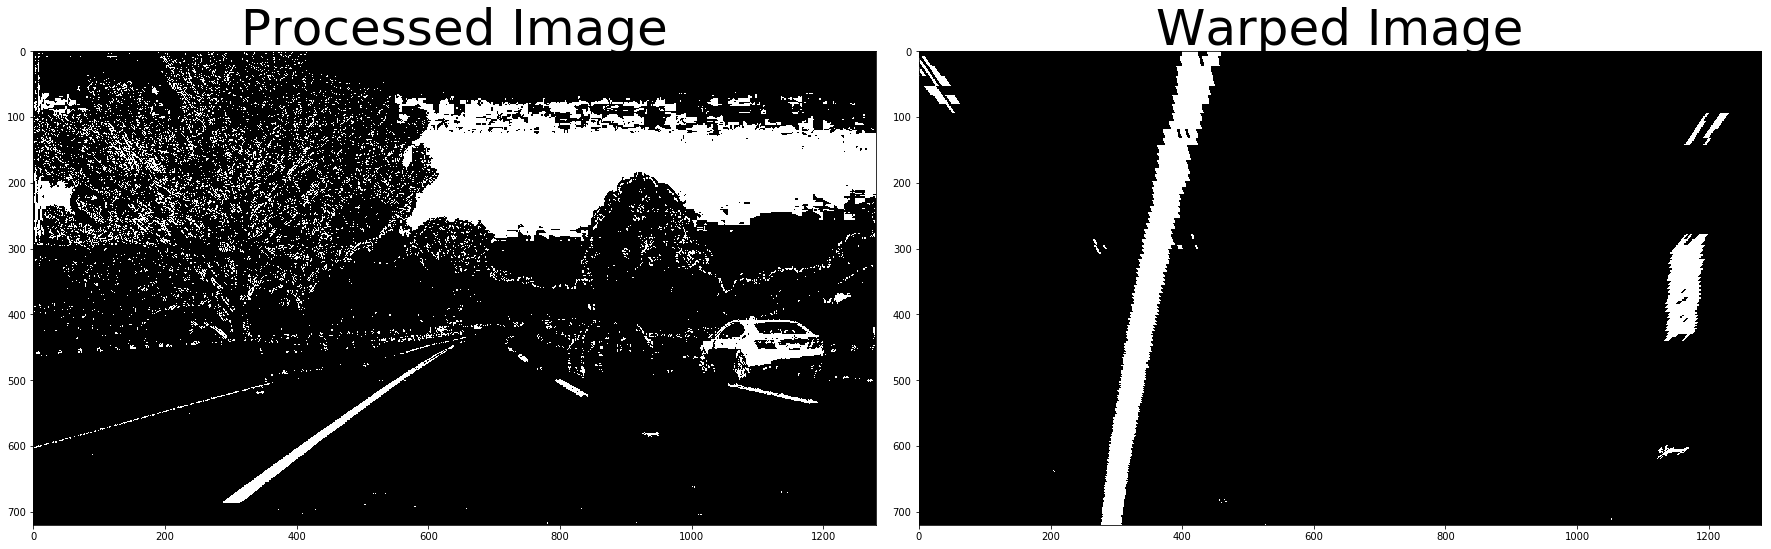

Left Curvature 1732.56 m
Right Curvature 1315.21 m
Vehicle Offset from the Middle -0.39 m
Average Curvature 1523.89 m


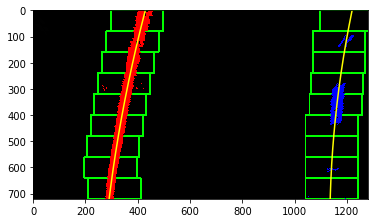

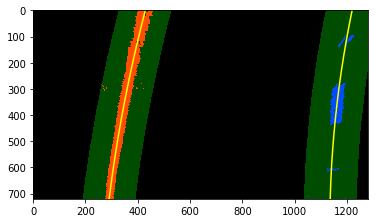

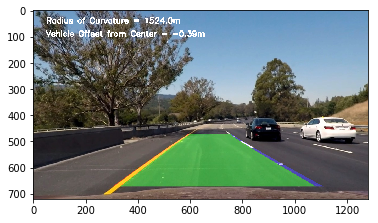

In [8]:
'''Pipeline with Test Images'''


# Read the test images
for filepath in glob.glob('test_images/*.jpg'): 
    img = mpimg.imread(filepath)
    file=filepath.split('\\')
    filename=file[1]
    
    
    '''Run the image distortion correction and save the undistorted images'''
    undistorted = cal_undistort(img, objpoints, imgpoints, mtx, dist)
    
    'Save image for the output folder'
    mpimg.imsave(target_undist+filename,undistorted)
    
    # Plot example results
    #f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    #f.tight_layout()
    #ax1.imshow(img)
    #ax1.set_title('Original Image', fontsize=50)
    #ax2.imshow(undistorted)
    #ax2.set_title('Undistorted Image', fontsize=50)
    #plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    #plt.show()    

    
    '''Call the pipeline to preprocess the undistorted images and save die preprocessed images'''
    result_comb = np.zeros_like(img[:,:,0])
    result_color = color_threshold(img, s_thresh=(100,255), v_thresh=(200,255))
    result_gradx = abs_sobel_thresh(img, orient='x', thresh=(25,255)) 
    result_grady = abs_sobel_thresh(img, orient='y', thresh=(25,255)) 
    result_comb[((result_gradx == 1) & (result_grady == 1) | (result_color == 1) )] = 255
    
    
    'Save image for the output folder'
    mpimg.imsave(target_pipeline_comb+filename,result_comb, cmap='gray') 
    
    
    '''Call the warper function to get a binary warped image'''
    src=np.float32([[753,480],
                    [537,480],
                    [190,700],
                    [1150,700]])

    
    dst=np.float32([[1140,100],
                    [200,100],
                    [200,740],
                    [1140,740]])
    
    binary_warped=warper(result_comb, src, dst)
    
    # Calculate the Transformation Matrix and the inverse Transformation Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    'Save image for the output folder'
    mpimg.imsave(target_warped+filename,binary_warped, cmap='gray')
    
    
    #Plot example results
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(result_comb, cmap='gray')
    ax1.set_title('Processed Image', fontsize=50)
    ax2.imshow(binary_warped, cmap='gray')
    ax2.set_title('Warped Image', fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    
    
    '''Finding the lanes on the binary warped image - Udacity Suggestion'''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
   
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.figure()
    
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    plt.imshow(result)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    plt.xlim(0, 1280)
    plt.ylim(720, 0)
    
    plt.figure()

    
    '''Calculate the Radius of Curvature'''
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
      
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    print('Left Curvature',"%.2f" % left_curverad, 'm')
    print('Right Curvature', "%.2f" % right_curverad, 'm')
   
    #Calculate the vehicle offset from the center   
    middle_fitx=(right_fitx[719]-left_fitx[719])/2 + left_fitx[719]
    vehicle_offset=((binary_warped.shape[1]/2)-middle_fitx)*xm_per_pix
    #print('Vehicle Offset from the Center of Road', "%.2f" % vehicle_offset, 'm')
    print('Vehicle Offset from the Middle', "%.2f" % vehicle_offset, 'm')
    
    #Calculate the average radius of curvature
    avg_curverad = (left_curverad + right_curverad)/2
    print('Average Curvature', "%.2f" % avg_curverad, 'm')

    
    '''Create an image to draw the line position on'''
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw lane markers
    pts = np.transpose(np.vstack([left_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.4, 0)
    
    # Draw the text showing curvature, offset
    cv2.putText(result,'Radius of Curvature = '+str(round(avg_curverad,0))+'m',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),3)
    cv2.putText(result,'Vehicle Offset from Center = '+str(round(vehicle_offset,2))+'m',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),3)
    
    
    plt.imshow(result)
    
    
cv2.destroyAllWindows()
  


In [7]:
'''Pipeline with project video'''

from moviepy.editor import VideoFileClip

import numpy as np
import cv2
import glob
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from os import path



def cam_cali(objpoints, imgpoints):
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs


def cal_undistort(img, objpoints, imgpoints, mtx, dist):
    ''' Function that takes an image, object points, and image points 
    performs the camera calibration, image distortion correction 
    and returns the undistorted image '''
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist 


def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(20, 100)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    grad_binary.astype(int)
    # Return the result
    return grad_binary


def color_threshold(img, s_thresh=(0,255), v_thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])  ] = 1

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])  ] = 1

    color_binary = np.zeros_like(s_channel)
    color_binary[(s_binary == 1) & (v_binary == 1)] = 1
    return color_binary


def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image
    return warped


def process_image(img):
    '''Run the image distortion correction and save the undistorted images'''
    undistorted = cal_undistort(img, objpoints, imgpoints, mtx, dist) 

    
    '''Call the pipeline to preprocess the undistorted images and save die preprocessed images'''
    #result = pipeline_hsv(undistorted, s_thresh=(170, 255), sx_thresh=(50, 255))
    result_comb = np.zeros_like(img[:,:,0])
    result_color = color_threshold(img, s_thresh=(100,255), v_thresh=(200,255))
    result_gradx = abs_sobel_thresh(img, orient='x', thresh=(25,255)) 
    result_grady = abs_sobel_thresh(img, orient='y', thresh=(25,255)) 
    result_comb[((result_gradx == 1) & (result_grady == 1) | (result_color == 1) )] = 255
       
    
    '''Call the warper function to get a binary warped image'''
    src=np.float32([[753,480],
                    [537,480],
                    [190,700],
                    [1150,700]])

    
    dst=np.float32([[1140,100],
                    [200,100],
                    [200,740],
                    [1140,740]])
    
    binary_warped=warper(result_comb, src, dst)
    
    # Calculate the Transformation Matrix and the inverse Transformation Matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    
    '''Finding the lanes on the binary warped image - Udacity Suggestion'''
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
   
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 5) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 5) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

    
    '''Calculate the Radius of Curvature'''
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])    
        
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    #Calculate the vehicle offset from the center   
    middle_fitx=(right_fitx[719]-left_fitx[719])/2 + left_fitx[719]
    vehicle_offset=((binary_warped.shape[1]/2)-middle_fitx)*xm_per_pix
    
    #Calculate the average radius of curvature
    avg_curverad = (left_curverad + right_curverad)/2
    

    '''Create an image to draw the line position on'''
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    
    # Draw lane markers
    pts = np.transpose(np.vstack([left_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (255,0,0), thickness=30)
    pts = np.transpose(np.vstack([right_fitx, ploty])).reshape((-1,1,2)).astype(np.int32)
    cv2.drawContours(color_warp, pts, -1, (0,0,255), thickness=30)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted, 1, newwarp, 0.4, 0)
    
     # Draw the text showing curvature, offset
    cv2.putText(result,'Radius of Curvature = '+str(round((avg_curverad/1000),2))+'km',(50,50) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),3)
    cv2.putText(result,'Vehicle Offset from Center = '+str(round(vehicle_offset,2))+'m',(50,100) , cv2.FONT_HERSHEY_SIMPLEX, 1,(255, 255, 255),3)
    
            
    return result


clip1 = VideoFileClip("project_video.mp4")
video_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
video_clip.write_videofile("output_video.mp4", audio=False)



[MoviePy] >>>> Building video output_video.mp4
[MoviePy] Writing video output_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:44<00:00,  3.66it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_video.mp4 

